In [1]:
from espuma import Case_Directory, Boundary_Probe

import pyvista as pv
import matplotlib.pyplot as plt

from re import findall
from math import hypot

pv.set_jupyter_backend('static')

In [2]:
def to_numeric(s:str):
    '''Quick regex to extract the values of an openfoam dict entry'''
    numbers = findall(r"[-]?\d+[.]?\d*", s)
    return [float(f) for f in numbers] if len(numbers) > 1 else float(numbers[0])


In [3]:
## Point to a template to clone from
of_template = Case_Directory("../templates/breakthrough")

## Clone case from the template
of_case = Case_Directory.clone_from_template(of_template, "example_column_btc")

## Create a postrprocessing folder in the case
(postp := of_case.path/"postProcessing").mkdir()

foamCloneCase /home/edwin/Repositories/espuma/examples/../templates/breakthrough example_column_btc finished successfully!


blockMesh finished successfully!


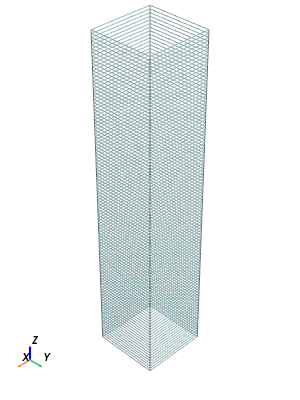

In [4]:
## Create mesh
of_case._blockMesh()

## Quick snapshot of the computational domain
reader= of_case.get_vtk_reader()
mesh = reader.read()
internalMesh = mesh['internalMesh']

plotter = pv.Plotter()
plotter.add_mesh(internalMesh, style='wireframe')
plotter.window_size = (300,400)
plotter.zoom_camera(1.30)
plotter.show_axes()
plotter.show()

## Setting up flow rate conditions

In [5]:
velocity = of_case.zero.U['internalField']
velocity = to_numeric(velocity)
velocity_mag = hypot(*velocity)
print(f"{velocity_mag = }")

velocity_mag = 0.001


In [6]:
# Get deltaZ in mesh
delta_z = float(of_case.system.blockMeshDict['deltaLenght'])
print(f"{delta_z = }")

delta_z = 0.01


\begin{equation*}
    \mathsf{CFL} = u \dfrac{\Delta t}{\Delta z} = 1 
    \quad \rightarrow \quad 
    \Delta t = \dfrac{\Delta z}{u}
\end{equation*}

In [7]:
# Set deltaT
of_case.system.controlDict['deltaT'] = delta_z/velocity_mag
print(f"{of_case.system.controlDict['deltaT'] = }")

of_case.system.controlDict['deltaT'] = '10'


## Setting up time controls

To model two column volumes:

\begin{equation}
    u = \dfrac{2\,L}{\mathtt{endTime}}
    \quad \rightarrow \quad
    \mathtt{endTime} = \dfrac{2\,L}{u}
\end{equation}

In [8]:
# Set endTime
column_lenght = float(of_case.system.blockMeshDict['lenght'])
end_time = 2.0 * column_lenght / velocity_mag
of_case.system.controlDict['endTime'] = end_time
print(f"{of_case.system.controlDict['endTime'] = }")

of_case.system.controlDict['endTime'] = '2000'


In [9]:
# Set writeInterval
n_times = 50
of_case.system.controlDict['writeControl'] = 'runTime'
of_case.system.controlDict['writeInterval'] = end_time // n_times
print(f"{of_case.system.controlDict['writeInterval'] = }")

of_case.system.controlDict['writeInterval'] = '40'


In [10]:
# Set probing time
n_times = 1_000
of_case.system.boundaryProbes['writeControl'] = 'runTime'
of_case.system.boundaryProbes['writeInterval'] = end_time // n_times
print(f"{of_case.system.boundaryProbes['writeInterval'] = }")

# Set probe format to CSV
print(f"Before:{of_case.system.boundaryProbes['setFormat'] = }")
of_case.system.boundaryProbes['setFormat'] = 'csv'
print(f"After:{of_case.system.boundaryProbes['setFormat'] = }")


of_case.system.boundaryProbes['writeInterval'] = '2'
Before:of_case.system.boundaryProbes['setFormat'] = 'raw'
After:of_case.system.boundaryProbes['setFormat'] = 'csv'


## Set up diffusion coefficient

In [11]:
of_case.constant.transportProperties["DT"] = 'DT [ 0 2 -1 0 0 0 0 ] 1e-8'

## Run case and plot BTC

In [12]:
of_case._runCase()

scalarTransportFoam finished successfully!


In [13]:
prb = Boundary_Probe(of_case, of_case.system.boundaryProbes)
data = prb.array_data

data

<xarray.Dataset> Size: 3kB
Dimensions:  (probes: 1, time: 200)
Coordinates:
  * probes   (probes) object 8B Point(x=0.0, y=0.0, z=0.0)
  * time     (time) float64 2kB 10.0 20.0 30.0 40.0 ... 1.98e+03 1.99e+03 2e+03
Data variables:
    T        (probes, time) float64 2kB 4.051e-31 1.36e-29 2.39e-28 ... 1.0 1.0

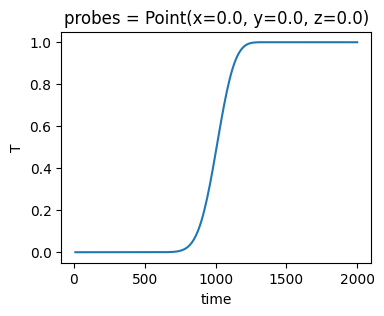

In [14]:
fig,ax = plt.subplots(figsize=[4,3])
data.isel(probes=0).T.plot.line(ax=ax)
plt.show()

Convert to relative concentration and column volumes

In [15]:
## Initial concentration
T0 = to_numeric(of_case.zero.T["boundaryField.top.uniformInletValue"])

## Probed concentration and time
T = data.isel(probes=0).T
time = data.time

## Convert to column volume
col_volume = velocity_mag * time / column_lenght

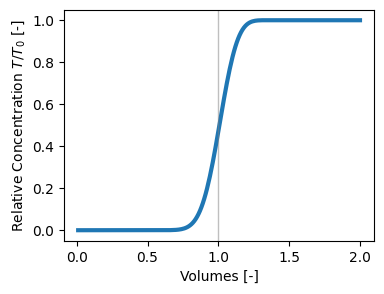

In [16]:
fig,ax = plt.subplots(figsize=[4,3])
ax.plot(col_volume, T/T0, lw=3)
ax.set_xlabel("Volumes [-]")
ax.set_ylabel("Relative Concentration $T/T_0$ [-]")
ax.axvline(x=1.0, lw=1, alpha=0.5, c='grey')
plt.show()